In [1]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
from utils import DataFrameImputer, plot_woe

(CVXPY) Feb 26 08:24:02 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 26 08:24:02 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/appuser/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# Load data set training and test sets
X_train = pd.read_csv('data/X_train.csv',index_col=['ID']) 
y_train = pd.read_csv('data/y_train.csv',index_col=['ID']).squeeze()
X_test = pd.read_csv('data/X_test.csv',index_col=['ID']) 
y_test = pd.read_csv('data/y_test.csv',index_col=['ID']).squeeze() 

In [3]:
# Define configurations for optimal binning
categorical_variables = ['VOMS_fail_Acute', 'VOMS_fail_Asymptomatic',
                        'VOMS_fail_Baseline', 'VOMS_fail_RTA',
                        'Injury_severity_A_pre_concussion',
                        'Injury_severity_B_pre_concussion',
                        'LOC', 'Hx_concussion', 'Hx_contact sport',
                        'contact level', 'Anxiety', 'ADD_ADHD', 'Depression',
                        'Psychiatric_Disorder', 'LD','Sports','Sex']
variable_names = list(X_train.columns)
binning_fit_params = {
    'VOMS_fail_Acute': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'VOMS_fail_Baseline': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'VOMS_fail_RTA': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'Anxiety': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'LOC': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'LD': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'Depression': {"user_splits":np.array([['no'],['yes']], dtype=object) },
    'Sex': {"user_splits":np.array([['male'],['female']], dtype=object) },
}

In [4]:
# Fit optimal binning and WoE transformation and apply it to training set
binning_process = BinningProcess(variable_names,
                                categorical_variables=categorical_variables,
                                binning_fit_params=binning_fit_params,
                                )
X_train_WOE = binning_process.fit_transform(X_train,y_train)
X_train_WOE = -1*X_train_WOE 
df_binining = binning_process.summary()

/home/appuser/.local/lib/python3.9/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
/home/appuser/.local/lib/python3.9/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: divide by zero encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


In [5]:
# Transform test set using learned WoE transformation
X_test_WOE = binning_process.transform(X_test)
X_test_WOE = -1*X_test_WOE

/home/appuser/.local/lib/python3.9/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
/home/appuser/.local/lib/python3.9/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: divide by zero encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


In [6]:
# Fit mean imputation and apply it to training set
imp_mean = DataFrameImputer()
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform="pandas")
scaler = StandardScaler().set_output(transform="pandas")
X_train_mean = imp_mean.fit_transform(X_train)
X_train_mean_cat = one_hot_encoder.fit_transform(X_train_mean.select_dtypes(include=['object']).copy())
X_train_mean_num = scaler.fit_transform(X_train_mean.select_dtypes(exclude=['object']).copy())
X_train_mean_all = pd.merge(right=X_train_mean_num,left=X_train_mean_cat,on='ID')

In [7]:
# Transform test set using mean imputation
X_test_mean = imp_mean.transform(X_test)
X_test_mean_cat = one_hot_encoder.transform(X_test_mean.select_dtypes(include=['object']).copy())
X_test_mean_num = scaler.transform(X_test_mean.select_dtypes(exclude=['object']).copy())
X_test_mean_all = pd.merge(right=X_test_mean_num,left=X_test_mean_cat,on='ID')

(0.0, 68.0)

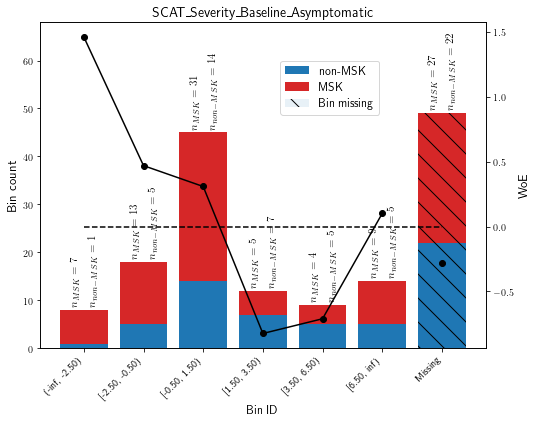

In [8]:
# Visualize transformed variable
var = 'SCAT_Severity_Baseline_Asymptomatic'
var_binned = binning_process.get_binned_variable(var).binning_table
fig,ax1,ax2 = plot_woe(var_binned, show_bin_labels=True, labels_events=['non-MSK','MSK'],
            reverse_woe=True, legend_position="upper center", legend_xy=(0.65,0.9),
            y_count_label=[-0.15,0.15], y_shift=0.0, metric='woe', add_missing=True)
ax1.set_ylim([0,68])